In [1]:
README = '''
Julian Smoller ~ 2018

The purpose of this project is to play around with the old computer game "Sim Tower." 
In this notebook, I attempt to replicate a Sim Tower as an image. 

Notes:
Optimal Tower design:
Width: 18 Condos = 32 Offices (exactly!)

Stairs:
Two sets of stairs, evenly spaced, no more than 8 offices away:
8 offices | stairs | 8 offices | 8 offices | stairs | 8 offices
=> 32 offices per floor
OOOOOOOO S OOOOOOOO OOOOOOOO S OOOOOOOO
=> one between 8th and 9th offices, one between 24th and 25th offices

Standard Elevators:
Three elevators, evenly spaced with 3 condos on either side:
CCC E CCC CCC E CCC CCC E CCC 
=> Between condos: (3,4), (9,10), (15,16)
3 elevators spanning floors (0,13), (15,28), (30,43), (45,58) => 12
2 elevators spanning floors (60,73) => 2
1 elevator spanning floors (73,100) => 1
==> 15 total

Express Elevators:
Horizontal location does not matter, so you can group them on the left or right
2 per lobby for floors 15, 30, 45, 60 => 8
1 for lobby for floor 75 => 1
==> 9 total
===> 24 elevators total


Floorplan:

30 Lobby
28-29 Food/Shops
24-27 Condos
19-23 Hotel
16-18 Offices
-------------
15 Lobby
13-14 Food/Shops
8-12 Hotel
5-7 Condos
4 Offices
1-3 Lobby
-------------

Income:
Ground floor lobby does not cost anything for maintenance
Each housekeeping unit costs 100(x100) per quarter for maintenance

'''

In [2]:
import os
import pandas as pd
import moviepy.editor as mpy
import math
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
import colorsys
import random
#import webcolors
import pickle
from Julian import *

%matplotlib inline

# Prepare data: sky

In [18]:
# Create + save color combos to pickle file
def mix_colors(colors,n=3):
    colors_new = []
    for i in range(n): # for each of the colors to be generated
        x = (i/(n-1))*(len(colors)-1) # map to list of colors given
        if x%1==0: # if exactly equal to a given color, e.g. last color
            color_new = colors[int(x)]
        else:  # need to mix two colors
            x0 = int(x)
            x1 = int(x+1)
            p1 = x%1 # percent of color 0
            p0 = 1-p1 # percent of color 1
            color0 = colors[x0]
            color1 = colors[x1]
            color_new = tuple([int(c0*p0+c1*p1) for c0,c1 in zip(color0,color1)])
        colors_new.append(color_new)
    return colors_new
#mix_colors([(0,0,0),(255,255,255)],n=3)

def create_sky_colors():
    n_color_combos = 100
    n_colors_per_combo = 8 # 1 per sky zone
    cc = [] # color combos recorded from game
    cc.append([(0,2,51),(1,3,64),(5,11,64),(0,2,47),
               (1,7,95),(29,50,111),(1,7,95),(0,2,47)]) # Night
    cc.append([(44,22,68),(44,26,68),(60,30,80),(52,25,59),
               (56,31,103),(81,66,100),(56,31,103),(52,25,59)]) # Sky 1
    cc.append([(68,34,76),(68,37,68),(84,38,88),(80,41,69),
               (84,47,111),(108,74,97),(84,47,111),(80,41,69)]) # Sky 2
    cc.append([(96,45,84),(96,53,69),(120,54,96),(116,57,77),
               (120,67,116),(145,82,94),(120,67,116),(116,57,77)]) # Sky 3
    cc.append([(120,57,93),(120,69,74),(145,62,105),(145,70,86),
               (149,79,120),(172,90,91),(149,79,120),(145,70,86)]) # Sky 4
    cc.append([(157,74,105),(157,85,75),(184,79,117),(184,90,98),
               (193,102,130),(213,102,85),(193,102,130),(184,90,98)]) # Sky 5
    cc.append([(184,90,114),(188,101,77),(221,91,131),(221,106,111),
               (225,122,135),(249,114,83),(225,122,135),(221,106,111)]) # Sky 6
    cc.append([(177,102,134),(177,117,99),(209,107,146),(217,122,126),
               (225,139,151),(249,130,102),(225,139,151),(217,122,126)]) # Sky 7
    cc.append([(153,122,161),(154,138,134),(185,131,169),(198,143,158),
               (214,159,174),(237,154,136),(214,159,174),(198,143,158)]) # Sky 8
    cc.append([(130,139,188),(126,154,169),(158,155,198),(182,166,185),
               (199,182,199),(230,182,171),(199,182,199),(182,166,185)]) # Sky 9
    cc.append([(111,155,213),(104,170,201),(139,175,217),(167,183,214),
               (186,199,218),(223,203,203),(186,199,218),(167,183,214)]) # Sky 10
    cc.append([(89,171,236),(86,187,233),(116,196,241),(152,204,237),
               (175,219,242),(211,227,235),(175,219,242),(152,204,237)]) # Sky 11
    cc.append([(82,179,248),(77,196,249),(106,204,249),(145,212,249),
               (168,227,259),(208,235,259),(168,227,259),(145,212,249)]) # Day
    cc_mixed = [[] for i in range(n_color_combos)]
    for i in range(n_colors_per_combo):
        colors = [combo[i] for combo in cc]
        colors_mixed = mix_colors(colors,n=n_color_combos)
        for j,color in enumerate(colors_mixed):
            cc_mixed[j].append(color)
    return cc_mixed
# cc = create_sky_colors()
# print(len(cc),'sky color combos created')
# pickle.dump(cc,open('data/sky/color_combos.p','wb'))

def get_blend_matrix(w,h):
    '''Generate a matrix of 0s and 1s, with increasing probability of 1 as rows increase'''
    blend_matrix = np.zeros((h,w),dtype=int)
    for x in range(w):
        for y in range(h):
            blend_matrix[y][x] = int(random.random()<(y/h))
    return blend_matrix
def fill_matrix(template,d):
    '''Populate matrix with values from dictionary (d) based on codes/keys in template'''
    matrix = []
    for row in template:
        new_row = []
        for cell in row:
            new_cell = d[cell]
            new_row.append(new_cell)
        matrix.append(new_row)
    return matrix

# Create and save sky template
def create_sky_template():
    '''Create a 2D array with color codes representing each sky zone'''
    w = 100
    h_sky_zone = 130
    h_blend_zone = 70
    n_sky_zones = 8 # should match number of colors in each color combo
    template = []
    blend_matrix = get_blend_matrix(w,h_blend_zone)
    for i in range(n_sky_zones):
        template.append(np.full((h_sky_zone,w),i))
        if i < n_sky_zones-1: # if sky zone is not the last sky zone, create blend zone
            template.append(fill_matrix(blend_matrix,{0:i,1:i+1}))
    template = np.concatenate(template)
    return template

# template = create_sky_template()
# pickle.dump(template,open('data/sky/template.p','wb'))
# print('created sky template of shape',template.shape)

# Sky

In [13]:
class Sky:
    t_dawn, t_day, t_dusk, t_night = 5,8,17,20
    schedule = [('night',t_dawn),('dawn',t_day),('day',t_dusk),('dusk',t_night),('night',24)]
    color_combos = pickle.load(open('data/sky/color_combos.p','rb'))
    template = pickle.load(open('data/sky/template.p','rb'))
    n_states = len(color_combos)
    def __init__(self,x=0,y=0,w=300,h=300):
        self.x, self.y, self.w, self.h = (x,y,w,h)
        self.t = None
        self.state = None
        self.changed = True 
        self.im = None
    def update(self,t):
        self.t = t
        self.update_state()
        self.update_color_combo()
    def update_state(self):
        state = next(x[0] for x in self.schedule if x[1]>=self.t) 
        if state == 'dawn':
            n = int(((self.t-self.t_dawn)/(self.t_day-self.t_dawn))*(self.n_states-1))
            state += '_' + str(n)
        elif state == 'dusk':
            n = int(((self.t-self.t_dusk)/(self.t_night-self.t_dusk))*(self.n_states-1))
            state += '_' + str(n)
        self.changed = (state != self.state) # keep track of state change from prior update
        self.state = state
    def update_color_combo(self):
        if self.state == 'night':
            color_combo = self.color_combos[0]
        elif self.state.startswith('dawn'):
            n = int(self.state.split('_')[1])
            color_combo = self.color_combos[n]
        elif self.state.startswith('dusk'):
            n = int(self.state.split('_')[1])
            color_combo = self.color_combos[-1*n] # inverted order
        else: # self.state = 'day':
            color_combo = self.color_combos[-1]
        self.color_combo = color_combo
    def create_image(self):
        im = Image.new('RGBA',(self.w,self.h),(0,0,0,0))
        for x in range(im.size[0]):
            c = x%self.template.shape[1] # template is probably too narrow, so wrap it
            for y in range(im.size[1]):
                r = min(y,self.template.shape[0]-1) # if template is too short, just use the max value
                color = self.color_combo[self.template[r,c]]
                im.putpixel((x,y),color)
        return im
    def image(self):
        # If first time rendering, or if state changed, then create a new image
        if self.im == None or self.changed==True:
            self.im = self.create_image()
        return self.im
    
# # Test
# sky = Sky()
# sky.update(12)
# sky.image()

# Camera

In [48]:
class Camera:
    path_frames = 'data/camera/frames/'
    path_video = 'data/camera/video.mp4'
    fps = 10
    def film(thing,t0,t1,logging=False):
        n_frames = int((t1-t0)*Camera.fps)
        paths = []
        for f in range(n_frames):
            if logging and f%10==0:
                print('processing frame ',f)
            t = t0 + (t1-t0)*f/n_frames
            thing.update(t)
            path = Camera.path_frames+str(f)+'.png'
            thing.image().save(path)
            paths.append(path)
        video = mpy.ImageSequenceClip(paths, fps=Camera.fps)
        video.write_videofile(Camera.path_video,fps=Camera.fps)
        return video
    
# sky = Sky()
# video = Camera.film(sky,0,24)
# video.ipython_display()

# Ground

In [10]:
class Ground:
    def __init__(self,x=0,y=0,w=100,h=400):
        self.x, self.y, self.w, self.h = (x,y,w,h)
        self.path = 'data/ground/template.png'
        self.im = self.create_image()
    def create_image(self):
        template = Image.open(self.path)
        im = Image.new('RGBA',(self.w,self.h),(0,0,0,255))
        for x in range(im.size[0]):
            for y in range(im.size[1]):
                x_template = x%template.size[0]
                y_template = min(y,template.size[1]-1)
                color = template.getpixel((x_template,y_template))
                im.putpixel((x,y),color)
        return im
    def image(self):
        return self.im
    
# Test
# ground = Ground()
# ground.image()

# Skyline

In [11]:
class Skyline:
    def __init__(self,x=0,y=0,w=100):
        self.x, self.y, self.w = (x,y,w)
        self.path = 'data/skyline/template.txt'
        self.colors = {'a':(16,125,125),'b':(11,101,100),'c':(28,178,177),'d':(6,77,77),
                       'e':(23,153,153),'f':(35,207,206),'g':(158,255,254),'h':(40,230,229),
                       'i':(45,254,254),'j':(88,254,254),'k':(2,47,47)}
        self.template = open(self.path,'r').read().split('\n')
        self.h = len(self.template)
        self.im = self.create_image() 
    def create_image(self):
        im = Image.new('RGBA',(self.w,self.h),(0,0,0,0))
        w_template = len(self.template[0]) # assuming all rows have same length as row 0
        for r in range(self.h):
            for c in range(self.w):
                color_code = self.template[r][c%w_template]
                if color_code in self.colors:
                    color = self.colors[color_code]
                    im.putpixel((c,r),color)
        return im
    def image(self):
        return self.im
    
# # Test
# skyline = Skyline()
# skyline.image()

# Background

In [18]:
class Background:
    h_ground = 360 # based on screenshot from game
    def __init__(self,w=1000,h=1000):
        self.w = w
        self.h = h
        self.t = None # should only be set using the "update" method 
        self.changed = True
        self.im = None
        self.ground = Ground(x=0, y=0, w=self.w, h=self.h_ground)
        self.sky = Sky(x=0, y=self.h_ground, w=self.w, h=self.h-self.h_ground)
        self.skyline = Skyline(x=0, y=self.sky.y, w=self.sky.w)
    def update(self,t):
        self.t = t
        self.sky.update(t)
        self.changed = self.sky.changed # need to reload background if sky changed
    def create_image(self):
        image = Image.new('RGBA',(self.w,self.h),(0,0,0,0))
        for thing in [self.ground, self.sky, self.skyline]:
            im = thing.image()
            xyxy = (thing.x, self.h-(thing.y+im.size[1]), thing.x+im.size[0], self.h-thing.y)
            image.paste(im,xyxy,im)
        return image
    def image(self):
        if self.im == None or self.changed: # if first time, or if image changed, create image
            self.im = self.create_image()
        return self.im

# Test
# background = Background()
# background.update(13)
# background.image()

# World

In [22]:
class World:
    def __init__(self,w=1000,h=1000):
        self.w = w
        self.h = h
        self.t = None
        self.changed = True
        self.background = Background(w=w,h=h)
        #self.tower = Tower() # relies on independent floorplan
        #self.tower.x = int((self.w-self.tower.w_outer)/2) # position tower horizontally (in the middle)
        #self.tower.y = self.sky.y - self.tower.h_underground # position tower vertically
        self.im = None
    def update(self,t):
        self.t = t
        self.background.update(t)
        #self.tower.update(t)
        self.changed = self.background.changed #or self.tower.changed
    def create_image(self):
        image = self.background.image()
        #im = self.tower.image()
        #xyxy = (self.tower.x, self.h-(self.tower.y+im.size[1]), self.tower.x+im.size[0], self.h-self.tower.y)
        #image.paste(im,xyxy,im)
        return image
    def image(self):
        if self.im == None or self.changed:
            self.im = self.create_image()
        return self.im

# Test
# world = World()
# world.update(13)
# world.image()

# Floor

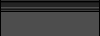

In [12]:
class Floor:
    template = 'axbccccdabexdddddddddddddddddddddddd'
    colors = {'x':(0,0,0),'a':(48,48,48),'b':(23,23,23),'c':(36,36,36),'d':(77,77,77),'e':(60,60,60)}
    h = len(template) # 36
    h_top_border = template.find('ddddddd')
    h_inner = h - h_top_border
    def create_image(w=100):
        im = Image.new('RGBA',(w,Floor.h),(0,0,0,0))
        for y in range(im.size[1]):
            for x in range(im.size[0]):
                color = (0,0,0,255) if x==0 or x==im.size[0]-1 else Floor.colors[Floor.template[y]]+(255,) 
                im.putpixel((x,y),color)
        return im
Floor.create_image()

# Lobby

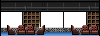

In [19]:
class Lobby:
    templates = {'lower':Image.open('data/tower/lower_lobby.png'),'sky':Image.open('data/tower/sky_lobby.png')}
    def create_image(w=100,lobby_type='sky'):
        template = Lobby.templates.get(lobby_type,Lobby.templates['sky'])
        im = Image.new('RGBA',(w,template.size[1]),(0,0,0,0))
        for x in range(im.size[0]):
            for y in range(im.size[1]):
                color = (0,0,0,255) if x==0 or x==im.size[0]-1 else template.getpixel((x%template.size[0],y))
                im.putpixel((x,y),color)
        return im
Lobby.create_image()

# Unit (base class)

In [56]:
class Unit:
    types = {'C':Condo}#,'O':Office,'FF':FastFood,'HS':HotelSingle,'HC':HotelCleaning,
            #'SC':SecurityCenter, 'R':Restaurant, 'PR':ParkingRamp,'PS':ParkingSpot}
    def __init__(self):
        self.t, self.state, self.im = (None,None,None)
        self.changed = True
    def get_state(self,t):
        return None # will vary for different units
    def update(self,t):
        self.t = t
        state = self.get_state(t)
        self.changed = state!=self.state
        self.state = state
    def create_image(self):
        return None # will vary for different units
    def image(self):
        if self.im == None or self.changed:
            self.im = self.create_image()
        return self.im

# Condo

In [57]:
class Condo(Unit):
    w = 128
    h = Floor.h_inner
    types = 'ABC'
    def __init__(self,code='C'):
        super(Condo, self).__init__()
        self.type = code.split('.')[1] if '.' in code else random.choice(Condo.types)
        t_day = random.uniform(5,8)
        t_evening = random.uniform(17,19)
        t_night = random.uniform(20,24)
        self.schedule = [('night',t_day),('day',t_evening),('evening',t_night),('night',24)]
    def get_state(self,t):
        return next(x[0] for x in self.schedule if x[1]>=t) 
    def create_image(self):
        return Image.open('data/condo/condo_'+self.type+'_'+self.state+'.png')
        
condo = Condo('C.C')
condo.update(12)
condo.image()

# Tower

In [58]:
class Tower:
    def __init__(self):
        self.x, self.y, self.t = (None, None, None) # will be set by world
        self.w = 128*5 # 5 condos
        self.floorplan = open('data/tower/floorplan.txt','r').read().split('\n')
        self.floors = self.create_floors()
        self.h = len(self.floors)*Floor.h
        self.base_im = self.create_base_im()
        self.units = self.create_units()
    def create_floors(self):
        floors = [{'name':row.split('|')[0],'units':row.split('|')[1:]} for row in self.floorplan]
        floors = pd.DataFrame(floors)
        floors['level'] = floors['name'].map(
            lambda f: 0 if f=='L' else (-1*int(f[1:]) if f.startswith('B') else int(f)))
        return floors
    def create_base_im(self):
        base_im = Image.new('RGBA',(self.w,self.h),(0,0,0,0))
        floor_im = Floor.create_image(self.w)
        for f, floor in self.floors.iterrows():
            base_im.paste(floor_im,(0,f*Floor.h,floor_im.size[0],f*Floor.h+floor_im.size[1]))
        for f,floor in self.floors[self.floors['level']%15==0].iterrows():
            lobby_im = Lobby.create_image(self.w,'lower') if floor.level==0 else Lobby.create_image(self.w,'sky')
            base_im.paste(lobby_im,(0,f*Floor.h,lobby_im.size[0],f*Floor.h+lobby_im.size[1]))
        return base_im
    def create_units(self):
        units = []
        for f,floor in self.floors.iterrows():
            x = 1 # start at 1 (because of border)
            for code in floor.units:
                if code.startswith(' '): # empty space
                    x+=len(code)*8 
                elif not code.startswith('#'): # for comments
                    unit_type = code.split('.')[0]
                    if unit_type in Unit.types:
                        unit = Unit.types[unit_type](code) # initialize with unit code
                        units.append({'unit':unit,'code':code,'x':x,'y':f*Floor.h,'w':unit.w,'h':unit.h})
                        x+=unit.w
        return units
        
tower = Tower()
tower.floors

TypeError: super(type, obj): obj must be an instance or subtype of type

# Old code:

In [32]:
# ================================================================================================
# ================================================================================================

class Tower:
    def __init__(self):
        self.x, self.y, self.t = (None, None, None) # will be set by world
        self.floorplan = FLOORPLAN
        self.w_inner = TOWER_WIDTH 
        self.w_outer = self.w_inner + (Awning.w*2)
        self.x_max = Awning.w + self.w_inner # right side of building
        self.floors = self.make_floors()
        self.h_inner = len(self.floors)*Floor.h
        self.h_outer = self.h_inner + Crane.h
        self.h_underground = abs(self.floors.level.min()*Floor.h)
        self.im = None
        self.units = self.make_units()
        self.changes = [] # used to track updates to units
    def make_floors(self):
        floorplan = self.floorplan.split('\n')[1:-1]
        floors = [{'name':row.split('|')[0],'units':row.split('|')[1:]} for row in reversed(floorplan)]
        floors = pd.DataFrame(floors)
        floors['level'] = floors['name'].map(
            lambda f: 0 if f=='L' else (-1*int(f[1:]) if f.startswith('B') else int(f)))
        floors['w'] = self.w_inner
        floors['h'] = Floor.h
        floors['x'] = Awning.w
        floors['y'] = floors.index.map(lambda i: i*Floor.h) # relative to lowest floor
        return floors
    def make_base_im(self):
        base_im = Image.new('RGBA',(self.w_outer,self.h_outer),(0,0,0,0))
        # Add floors
        floor_im = Floor.render(self.w_inner)
        for f,floor in self.floors.iterrows():
            x0 = floor.x
            x1 = x0 + floor.w
            y1 = base_im.size[1] - floor.y
            y0 = y1 - floor.h
            base_im.paste(floor_im,(x0,y0,x1,y1))
        # Add lobbies
        for f,floor in self.floors[self.floors['level']%15==0].iterrows():
            lobby_type = 'lower' if floor.level==0 else 'sky'
            lobby_im = Lobby.render(w=floor.w,lobby_type=lobby_type)
            x0 = floor.x
            x1 = x0 + floor.w
            y1 = base_im.size[1] - floor.y
            y0 = y1 - lobby_im.size[1]
            base_im.paste(lobby_im,(x0,y0,x1,y1)) # no mask, because we want to replace the floor image
        # Add fire escapes
        for f,floor in self.floors[self.floors['level']>=0].iterrows():
            y1 = base_im.size[1] - floor.y
            y0 = y1 - FireEscape.h
            base_im.paste(FireEscape.left,(floor.x-FireEscape.w,y0,floor.x,y1),FireEscape.left)
            base_im.paste(FireEscape.right,(floor.x+floor.w,y0,floor.x+floor.w+FireEscape.w,y1),FireEscape.right)
        # Add crane
        base_im.paste(Crane.im,(Awning.w,0,Awning.w+Crane.w,Crane.h),Crane.im)
        return base_im
    def make_units(self):
        classes = {'O':Office,'C':Condo,'FF':FastFood,'HS':HotelSingle,'HC':HotelCleaning,
                   'SC':SecurityCenter, 'R':Restaurant, 'PR':ParkingRamp,'PS':ParkingSpot}
        units = []
        for f,floor in self.floors.iterrows():
            x = floor.x+1 # reset x to the left side of the floor (+1 for border)
            for code in floor.units:
                if code.startswith(' '): # empty space
                    x+=len(code)*8
                elif not code.startswith('#'): # for comments
                    unit = classes[code.split('.')[0]]((x,floor.y),code) # initialize with xy and unit code
                    x+=unit.w
                    units.append(unit)
        return units
    def list_units(self,units=None):
        if units==None:
            units = self.units
        units = pd.DataFrame({'unit':units})
        units['code'] = units['unit'].map(lambda u: u.code)
        units['x'] = units['unit'].map(lambda u: u.x)
        units['y'] = units['unit'].map(lambda u: u.y)
        units['w'] = units['unit'].map(lambda u: u.w)
        units['h'] = units['unit'].map(lambda u: u.h)
        units['state'] = units['unit'].map(lambda u: u.state)
        units['path'] = units['unit'].map(lambda u: u.path)
        return units
    def update(self,t):
        self.t = t
        self.changes = []
        for unit in self.units:
            state_before = unit.state
            unit.update(self.t)
            state_after = unit.state
            if state_before != state_after:
                self.changes.append(unit)
    def render(self):
        # If first time rendering, need to create base image and render all units 
        if self.im == None:
            self.im = self.make_base_im()
            units_to_render = self.units
        # Otherwise, just render the units that changed
        else:
            units_to_render = self.changes
        for unit in units_to_render:
            im = unit.render()
            # Crop to fit if necessary
            if unit.x + im.size[0] > self.x_max: # image does not fit in bounds
                im = im.crop((0, 0, self.x_max - unit.x, im.size[1]))
            # Calculate box to paste image
            x0 = unit.x
            x1 = unit.x + im.size[0]
            y0 = self.im.size[1] - (unit.y+im.size[1])
            y1 = y0 + im.size[1]
            self.im.paste(im,(x0,y0,x1,y1)) # no mask, because we want to replace floor image
        return self.im
            
class Floor:
    template = 'axbccccdabexdddddddddddddddddddddddd'
    colors = {'x':(0,0,0),'a':(48,48,48),'b':(23,23,23),'c':(36,36,36),'d':(77,77,77),'e':(60,60,60)}
    h = len(template) # 36
    h_top_border = template.find('ddddddd')
    h_inner = h - h_top_border
    get_level = lambda f: 0 if f=='L' else (-1*int(f[1:]) if f.startswith('B') else int(f))
    def render(w):
        im = Image.new('RGBA',(w,Floor.h),(0,0,0,0))
        for y in range(im.size[1]):
            color_code = Floor.template[y]
            color = Floor.colors[color_code]
            for x in range(im.size[0]):
                im.putpixel((x,y),color+(255,))
        im = add_left_right_border(im,(0,0,0,255))
        return im
class FireEscape:
    w = 24
    h = Floor.h
    left = Image.open('data/fire_escape/fire_escape_left_render.png')
    right = Image.open('data/fire_escape/fire_escape_left_render.png')
class Awning:
    w = 33 # just a guess
class Crane:
    w = 36
    h = 36
    path = 'data/crane/crane_render.png'
    im = Image.open(path)
class Lobby:
    templates = {}
    templates['lower'] = Image.open('data/lobby/lower_lobby_template.png')
    templates['sky'] = Image.open('data/lobby/sky_lobby_template.png')
    def render(w=100,lobby_type='sky'):
        template = Lobby.templates[lobby_type]
        im = Image.new('RGBA',(w,template.size[1]),(0,0,0,0))
        for c in range(im.size[0]):
            for r in range(im.size[1]):
                color = template.getpixel((c%template.size[0],r))
                im.putpixel((c,r),color)
        im = add_left_right_border(im,(0,0,0,255))
        return im

# ================================================================================================
# ================================================================================================

class Unit:
    def __init__(self,xy,code):
        self.x,self.y = xy
        self.h = 24 # standard for 1-floor unit
        self.code = code 
        self.state = None
        self.path = None
    def update(self,t):
        self.t = t
    def render(self):
        return Image.open(self.path)
class HotelCleaning(Unit):
    w = 120
    def __init__(self,xy,code):
        super(HotelCleaning, self).__init__(xy, code)
        self.path = 'data/hotel/images/render/hotel_cleaning.png'
class SecurityCenter(Unit):
    w = 128
    states = 'AB'
    def __init__(self,xy,code):
        super(SecurityCenter, self).__init__(xy, code)
    def update(self,t):
        self.t = t
        self.update_state()
        self.update_path()
    def update_state(self):
        self.state = self.states[round(self.t%1)]
    def update_path(self):
        self.path = 'data/security_center/security_center_' + self.state + '.png'
class Office(Unit):
    w = 72
    def __init__(self,xy,code):
        super(Office, self).__init__(xy, code)
        self.category = code.split('.')[1] if '.' in code else random.choice('ABCDEF')
        self.t_wakeup = random.uniform(5,11)
        self.t_bedtime = random.uniform(17,21)
    def update(self,t):
        self.t = t
        self.state = 'awake' if self.t>self.t_wakeup and self.t<self.t_bedtime else 'asleep'
        self.path = 'data/office/images/render/office_'+self.category+'_'+self.state+'.png'
# class Condo(Unit):
#     w = 128
#     def __init__(self,xy,code):
#         super(Condo, self).__init__(xy, code)
#         self.category = code.split('.')[1] if '.' in code else random.choice('ABC')
#         t_wakeup = random.uniform(5,8)
#         t_evening = random.uniform(17,19)
#         t_bedtime = random.uniform(20,24)
#         self.schedule = [('night',t_wakeup),('day',t_evening),('evening',t_bedtime),('night',24)]
#     def update(self,t):
#         self.t = t
#         self.state = next(x[0] for x in self.schedule if x[1]>=self.t) 
#         self.path = 'data/condo/'+self.category+'/'+self.state+'.png'
class FastFood(Unit):
    w = 128
    def __init__(self,xy,code):
        super(FastFood, self).__init__(xy, code)
        self.category = code.split('.')[1] if '.' in code else random.choice('ABCDE') 
        t_open = 9
        t_close = 21 # 9pm
        t_lunch_start = random.uniform(10,13)
        t_lunch_end = t_lunch_start + 3
        t_dinner_start = random.uniform(16,19)
        t_dinner_end = t_dinner_start + 2
        self.schedule = [('closed',t_open),('open_empty',t_lunch_start),('open_busy',t_lunch_end),
                         ('open_empty',t_dinner_start),('open_busy',t_dinner_end),('closed',24)]
    def update(self,t):
        self.t = t
        self.state = next(x[0] for x in self.schedule if x[1]>=self.t)
        self.path = 'data/fast_food/images/render/fast_food_' + self.category + '_' + self.state + '.png'
class Restaurant(Unit):
    w = 192
    def __init__(self,xy,code):
        super(Restaurant, self).__init__(xy, code)
        self.category = code.split('.')[1] if '.' in code else random.choice('ABCDE') 
        t_open = 17 # 5pm
        t_close = 23 # 11pm
        t_people_arrive = random.uniform(17,18)
        t_crowds_arrive = random.uniform(19,20)
        t_crowds_leave = random.uniform(20,21)
        t_people_leave = random.uniform(22,23)
        self.schedule = [('closed',t_open),('empty',t_people_arrive),('busy',t_crowds_arrive),
                         ('crowded',t_crowds_leave),('busy',t_people_leave),('empty',t_close),('closed'),24]
    def update(self,t):
        self.t = t
        self.state = next(x[0] for x in self.schedule if x[1]>=self.t)
        self.path = 'data/restaurant/images/render/' + self.category + '/' + self.state + '.png'
class HotelSingle(Unit):
    w = 32
    def __init__(self,xy,code):
        super(HotelSingle, self).__init__(xy, code)
        self.category = code.split('.')[1] if '.' in code else random.choice('AB')
        t_dawn, t_day, t_dusk, t_night = (5,9,17,20)
        t_wakeup = random.uniform(t_dawn,t_day)
        t_checkout = random.uniform(t_day,t_dusk)
        t_checkin = random.uniform(t_dusk,t_night)
        t_bedtime = random.uniform(t_night, 24)
        self.schedule = [('night',t_wakeup),('morning',t_checkout),('day',t_dusk),
                         ('dark_empty',t_checkin),('evening',t_bedtime),('night',24)]
    def update(self,t):
        self.t = t
        self.state = next(x[0] for x in self.schedule if x[1]>=self.t)
        self.path = 'data/hotel/images/render/hotel_single_'+self.category+'_'+self.state+'.png'
class ParkingRamp(Unit):
    w = 128
    states = {'O':'open','C':'closed'}
    def __init__(self,xy,code):
        super(ParkingRamp, self).__init__(xy, code)
        self.state = ParkingRamp.states[code.split('.')[1]] if '.' in code else 'open' 
        self.path = 'data/parking/ramp/'+ self.state + '.png'
class ParkingSpot(Unit):
    w = 32
    cars = ['red1','red2','red3','blue1','blue2','blue3','blue4','green1','green2','white1','yellow1','grey1']
    usage = 0.8
    def __init__(self,xy,code):
        super(ParkingSpot, self).__init__(xy, code)
        self.car = random.choice(ParkingSpot.cars)
        self.used = random.random() < ParkingSpot.usage # does anyone ever park there
        if self.used:
            t_car_parks = random.uniform(5,12)
            t_car_leaves = random.uniform(t_car_parks,24)
            self.schedule = [('empty',t_car_parks),('full',t_car_leaves),('empty',24)]
        else: 
            self.schedule = [('empty',24)]
    def update(self,t):
        self.t = t
        self.state = next(x[0] for x in self.schedule if x[1]>=self.t)
        self.path = 'data/parking/spot/' + self.state + '/'
        if self.state == 'empty':
            self.path += 'empty.png'
        else: 
             self.path +=  self.car + '.png'
        
print('Done')

FileNotFoundError: [Errno 2] No such file or directory: 'data/fire_escape/fire_escape_left_render.png'

In [33]:
TOWER_WIDTH = 128*5
FLOORPLAN = '''
15|### Lobby
14|C|C|C|C|C
13|C|C|C|C|C
12|HS|HS|HS|HS| |HC| |HS|HS|HS|HS
11|HS|HS|HS|HS| |HC| |HS|HS|HS|HS
10|O|O|O|O|O|O|O|O|O
9|O|O|O|O|O|O|O|O|O
8|R.A| |FF.A
7|R.B| |FF.B
6|R.C| |FF.C
5|R.D| |FF.D
4|R.E| |FF.E
3|#
2|### Lobby
1|### Lobby
L|### Lobby
B1|PR.O| |SC
B2|PR.O
B3|PR.O
B4|PR.O
B5|PR.O|PS|PS|PS|PS|PS|PS|PS|PS|PS|PS|PS|PS|PS|PS|PS|PS
B6|PR.C|PS|PS|PS|PS|PS|PS|PS|PS|PS|PS|PS|PS|PS|PS|PS|PS
'''
world = World()

NameError: name 'World' is not defined

In [ ]:
# def create_video():
#     t_start = 0
#     t_end = 24
#     seconds_per_t = 1
#     n_seconds = (t_end-t_start)*seconds_per_t
#     print(n_seconds,'seconds')
#     frames_per_second = 10
#     n_frames = int(n_seconds*frames_per_second)
#     print(n_frames,'frames')
#     paths = []
#     for i in range(n_frames):
#         t = (i/n_frames)*(t_end-t_start)+t_start
#         path = 'data/video_image_frames/frame_'+str(i)+'.png'
#         print('t',t,path)
#         paths.append(path)
#         world.update(t)
#         im = world.render()
#         im.save(path)

#     video = mpy.ImageSequenceClip(paths, fps=frames_per_second)
#     path_out = 'data/video_output/simtower.mp4'
#     video.write_videofile(path_out,fps=frames_per_second)